# SSLTelecom

## Problema

Te escribimos de la peluquería SSL, esta pandemia – entre otras cosas –, ha afectado a nuestro negocio, que a veces parece que está a punto de cerrar, para nuestro disgusto. Como no queremos rendirnos tan fácilmente, hemos pensado en abrir un nuevo negocio de **venta de teléfonos móviles** para ver si sacamos suficientes beneficios para mantener la pelu a flote.

Supongo que a estas alturas, te estarás preguntando: ¿y yo qué pinto en el negocio? Pues la verdad, es que no sabemos muy bien qué precio ponerle a nuestros teléfonos móviles y no queremos quedar atrás de nuestros competidores. Es por eso que necesitamos la ayuda de un **orfebre Data Scientist** que nos ayude a estimar correctamente el rango de precio de un teléfono móvil (bajo/medio/alto) para nosotras podernos hacer una idea del precio final al que podemos venderlo y no perder dinero.

Hemos adjuntado el fichero con los datos que tenemos disponibles actualmente. Si necesitas un diccionario con información relativa a los datos, háznoslo saber.

## Datos

- **Battery power**: indica la batería del móvil expresada en mAh
- **Blue**: indica si el móvil tiene bluetooth (1) o no (0)
- **Clock speed**: indica la rapidez de procesamiento
- **Dual sim**: indica si el móvil soporta dos SIM (1) o no (0)
- **Fc**: megapíxeles de la cámara frontal
- **Four_g**: indica si el móvil tiene 4G (1) o no (0)
- **Int_memory**: memoria interna expresada en Gb
- **M_dep**: grosor del teléfono móvil
- **Mobile_wt**: peso del teléfono móvil
- **N_cores**: número de cores del procesador
- **Pc**: megapíxeles de la cámara principal
- **Px_height**: resolución de píxeles (altura)
- **Px_width**: resolución de píxeles (ancho)
- **Ram**: RAM del móvil expresada en MegaBytes
- **Sc_h**: altura de la pantalla del móvil expresada en cm
- **Sc_w**: ancho de la pantalla del móvil expresada en cm
- **Talk time**: duración de la batería durante una conversación
- **Three_g**: indica si el móvil tiene 3G (1) o no (0)
- **Touch_screen**: indica si la pantalla del móvil es táctil (1) o no (0)
- **WiFi**: indica si el móvil tiene WiFi (1) o no (0)
- **Price-range**: indica si el móvil es de costo bajo (0), medio (1), alto (2) o muy alto (3)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import pandas as pd

DATA_FILEPATH = '../data/mobile_phone_info.csv'
df = pd.read_csv(DATA_FILEPATH)
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Modificando variables

Como vimos en el análisis exploratorio, las variables `px_height` y `sc_w` tienen valores que no son válidos. En ambos casos, estamos hablando de variables de tamaños. Vamos a calcular la ratio entre el ancho y el alto y vamos a aplicarla a la otra variable de tamaño para calcular el nuevo valor.

Calculamos la moda del ratio de la resolución de pantalla.

In [3]:
valid_px_height = df[df['px_height'] >= 500]
px_ration = valid_px_height['px_width'] / valid_px_height['px_height']
px_ration_mode = px_ration.mode()[0]
print(f"Moda de px_ration", px_ration_mode)

Moda de px_ration 1.1714285714285715


Calculamos la moda del ratio del tamaño de pantalla.

In [4]:
valid_sc_w = df[df['sc_w'] >= 3]
sc_ration = valid_sc_w['sc_w'] / valid_sc_w['sc_h']
sc_ration_mode = sc_ration.mode()[0]
print(f"Moda de sc_ration", sc_ration_mode)

Moda de sc_ration 0.5


### Creamos los Transformers

Lo primero es crear unos Transformers para eliminar los valores inválidos de la resolución y tamaño de pantalla. Para ello creamos el `ReplacePxRatio` y `ReplaceScRatio`.

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class ReplacePxRatio(BaseEstimator, TransformerMixin):
    def __init__(self, min_height_valid):
        self.min_height_valid = min_height_valid
    def fit(self, X, y=None):
        valid_px_height = X[X['px_height'] >= self.min_height_valid]
        px_ration = valid_px_height['px_width'] / valid_px_height['px_height']
        self.px_ration_mode = px_ration.mode()[0]
        return self
    def transform(self, X):
        new_df = X.copy()
        new_df['px_height'] = np.where(X['px_height'] >= self.min_height_valid, X['px_height'], X['px_width'] * self.px_ration_mode)
        return new_df
    
class ReplaceScRatio(BaseEstimator, TransformerMixin):
    def __init__(self, min_width_valid):
        self.min_width_valid = min_width_valid
    def fit(self, X, y=None):
        valid_sc_width = X[X['sc_w'] >= self.min_width_valid]
        sc_ration = valid_sc_width['sc_w'] / valid_sc_width['sc_h']
        self.sc_ration_mode = sc_ration.mode()[0]
        return self
    def transform(self, X):
        new_df = X.copy()
        new_df['sc_w'] = np.where(X['sc_w'] >= self.min_width_valid, X['sc_w'], X['sc_h'] * self.sc_ration_mode)
        return new_df

In [6]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

## Pipelines

Vamos a crear un Pipeline para trabajar sobre las variables numéricas y otro para trabajar con las variables categóricas.

A continuación, los uniremos para crear el Pipeline completo.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('replace_px_ratio', ReplacePxRatio(500)),
        ('replace_sc_ratio', ReplaceScRatio(2)),
        ('std_scaler', StandardScaler())
    ])

In [8]:
from sklearn.compose import ColumnTransformer

num_attribs = ['battery_power','clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w','talk_time']
cat_attribs = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", DummyTransformer(), cat_attribs),
    ])

## Entrenamiento

Primero vamos a hacer el split entre el entrenamiento y la validación.

In [3]:
from sklearn.model_selection import train_test_split

y = df['price_range']
X = df.drop(['price_range'], axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.30, random_state=1)

Vamos a preparar nuestros datos de entrenamiento y test con el Pipeline que hemos creado anteriormente.

In [10]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_validation_prepared = full_pipeline.fit_transform(X_validation)

In [11]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt

def show_feature_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
def predict_and_evaluate(model, X_train, y_train, X_validation, y_validation): 
    model.fit(X_train, y_train)
    evaluate(model, X_train, y_train, X_validation, y_validation)
    return model
    
def fit_grid_search_and_evaluate_best_estimator(model, X_train, y_train, X_validation, y_validation): 
    model.fit(X_train, y_train)
    evaluate(model.best_estimator_, X_train, y_train, X_validation, y_validation)
    return model.best_estimator_
    
def evaluate(model, X_train, y_train, X_validation, y_validation): 
    y_predicted = model.predict(X_validation)

    print("Recall:", recall_score(y_validation, y_predicted, average='macro'))
    print("Precision:", precision_score(y_validation, y_predicted, average='macro'))
    print("Accuracy:", accuracy_score(y_validation, y_predicted))
    print("F1 Score:", f1_score(y_validation, y_predicted, average='macro'))

    if hasattr(model, 'feature_importances_'):
        show_feature_importances(model.feature_importances_, [*num_attribs, *cat_attribs])
    if hasattr(model, 'coef_'):
        show_feature_importances(abs(model.coef_[0]), [*num_attribs, *cat_attribs])
        

    plot_confusion_matrix(model, X_validation, y_validation)  
    plt.show()


Vamos a probar con algunos de los algoritmos de clasificación multiclase.

https://scikit-learn.org/stable/modules/multiclass.html

### DecisionTreeClassifier

Recall: 0.8007268211110568
Precision: 0.7972634994591896
Accuracy: 0.7977777777777778
F1 Score: 0.7957813132188891


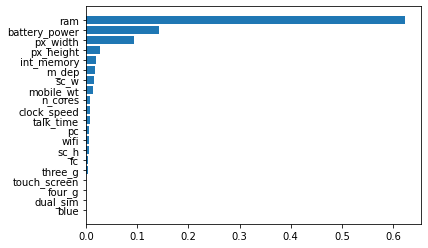

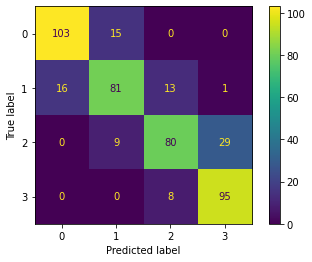

DecisionTreeClassifier(random_state=0)

In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

predict_and_evaluate(clf, X_train_prepared, y_train, X_validation_prepared, y_validation)

### SVC

Recall: 0.8722357374652915
Precision: 0.8705790960451978
Accuracy: 0.8711111111111111
F1 Score: 0.8704358052890186


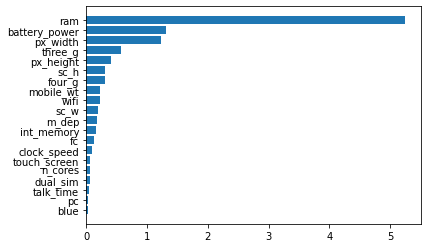

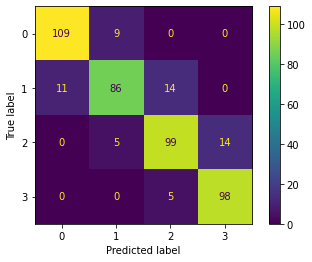

SVC(gamma='auto', kernel='linear')

In [13]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', kernel='linear')

predict_and_evaluate(svc, X_train_prepared, y_train, X_validation_prepared, y_validation)

### NuSVC

Recall: 0.8637611611941051
Precision: 0.8614432338194129
Accuracy: 0.8622222222222222
F1 Score: 0.8616442584043982


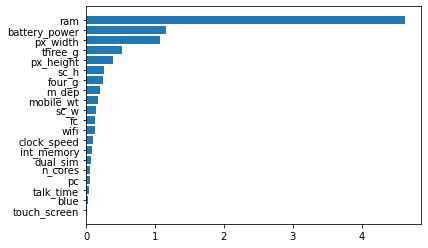

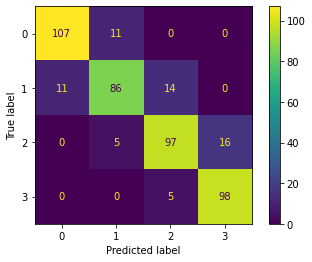

NuSVC(gamma='auto', kernel='linear', nu=0.2)

In [14]:
from sklearn.svm import NuSVC

nu_svc = NuSVC(nu=0.2, gamma='auto', kernel='linear')

predict_and_evaluate(nu_svc, X_train_prepared, y_train, X_validation_prepared, y_validation)

### SGDClassifier

Recall: 0.7585192358723707
Precision: 0.7560769297334717
Accuracy: 0.7533333333333333
F1 Score: 0.7528775327322499


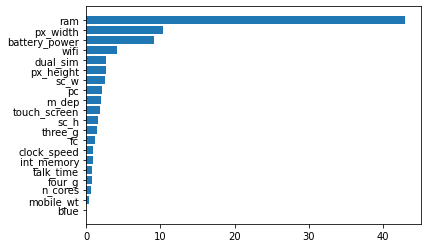

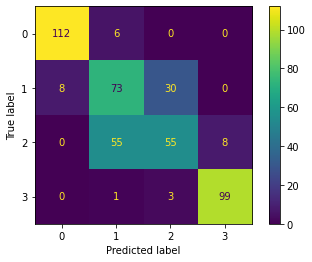

SGDClassifier()

In [15]:
from sklearn.linear_model import SGDClassifier

sdg = SGDClassifier(max_iter=1000, tol=1e-3)

predict_and_evaluate(sdg, X_train_prepared, y_train, X_validation_prepared, y_validation)

### KNeighborsClassifier

Recall: 0.5170173464562143
Precision: 0.5268492484974282
Accuracy: 0.5177777777777778
F1 Score: 0.5171974890680606


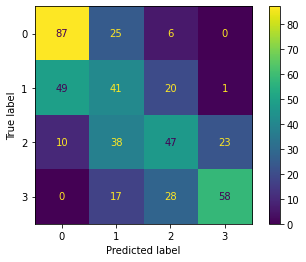

KNeighborsClassifier(n_neighbors=3)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

predict_and_evaluate(neigh, X_train_prepared, y_train, X_validation_prepared, y_validation)

### RandomForestClassifier

Recall: 0.8133464013626923
Precision: 0.8073685311311296
Accuracy: 0.8111111111111111
F1 Score: 0.8069203242334122


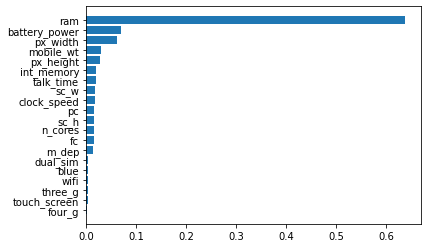

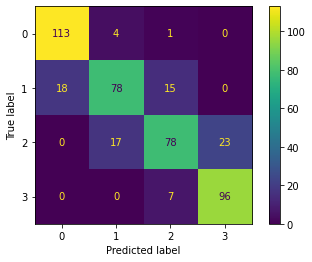

RandomForestClassifier(max_depth=5, random_state=0)

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)

predict_and_evaluate(clf, X_train_prepared, y_train, X_validation_prepared, y_validation)

In [18]:
num_attribs = ['battery_power','clock_speed', 'int_memory', 'm_dep', 'mobile_wt', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w']
cat_attribs = ['blue', 'touch_screen', 'wifi']

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.columns, axis=1)

num_pipeline = Pipeline([
    ('replace_px_ratio', ReplacePxRatio(500)),
    ('replace_sc_ratio', ReplaceScRatio(2)),
    ('drop_columns', DropColumns(['sc_w'])),
    ('std_scaler', StandardScaler())
])
    
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", DummyTransformer(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_validation_prepared = full_pipeline.fit_transform(X_validation)

Recall: 0.9050842639578858
Precision: 0.9047352331386985
Accuracy: 0.9044444444444445
F1 Score: 0.9039945052923376


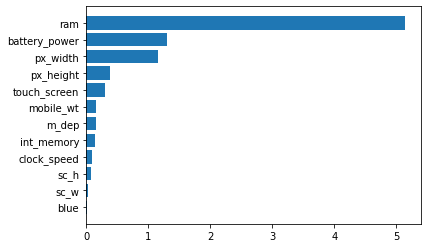

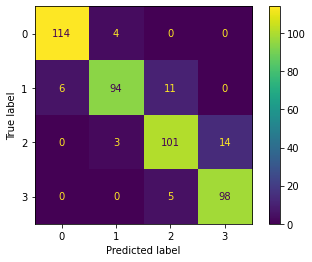

SVC(gamma='auto', kernel='linear')

In [19]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', kernel='linear')

predict_and_evaluate(svc, X_train_prepared, y_train, X_validation_prepared, y_validation)

Recall: 0.8922387913666505
Precision: 0.8909043303439855
Accuracy: 0.8911111111111111
F1 Score: 0.8909843544492233


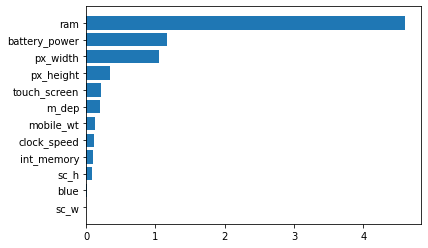

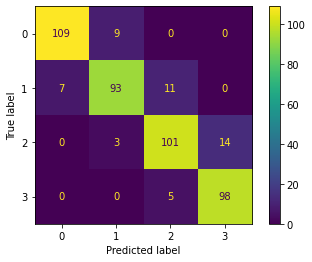

NuSVC(gamma='auto', kernel='linear', nu=0.2)

In [20]:
from sklearn.svm import NuSVC

nu_svc = NuSVC(nu=0.2, gamma='auto', kernel='linear')

predict_and_evaluate(nu_svc, X_train_prepared, y_train, X_validation_prepared, y_validation)

Recall: 0.8409905091861649
Precision: 0.8368802440884822
Accuracy: 0.8377777777777777
F1 Score: 0.8353844323162849


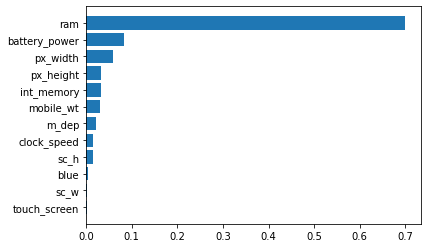

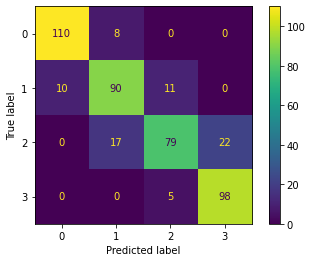

RandomForestClassifier(max_depth=5, random_state=0)

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)

predict_and_evaluate(clf, X_train_prepared, y_train, X_validation_prepared, y_validation)

### Refinar el modelo

Ahora, vamos a refinar el algoritmo, modificando los hyperparámetros.

Recall: 0.9050842639578858
Precision: 0.9047352331386985
Accuracy: 0.9044444444444445
F1 Score: 0.9039945052923376


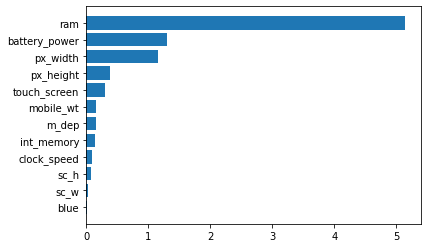

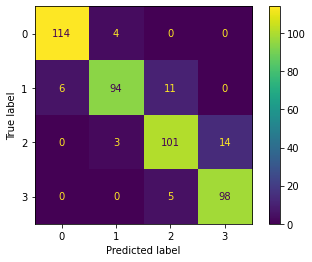

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}


In [22]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 'C':[1, 10], 'gamma': ['scale', 'auto'],
             'decision_function_shape': ['ovo', 'ovr']}
grid_search = GridSearchCV(SVC(), parameters)
fit_grid_search_and_evaluate_best_estimator(grid_search, X_train_prepared, y_train, X_validation_prepared, y_validation)
print(grid_search.best_params_)

Recall: 0.8988619399389516
Precision: 0.8974145562076243
Accuracy: 0.8977777777777778
F1 Score: 0.897581736577158


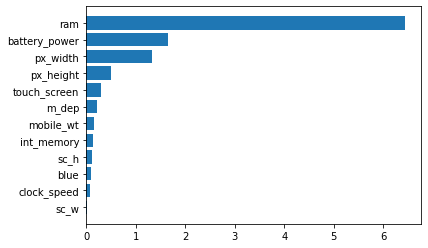

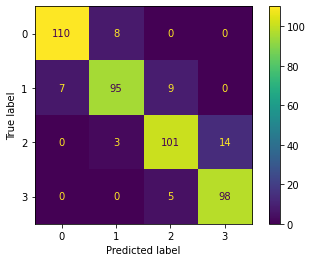

{'decision_function_shape': 'ovo', 'kernel': 'linear', 'nu': 0.15}


In [23]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 
            'nu': [0.15, 0.2, 0.25],
            'decision_function_shape': ['ovo', 'ovr']}
grid_search = GridSearchCV(NuSVC(), parameters)
fit_grid_search_and_evaluate_best_estimator(grid_search, X_train_prepared, y_train, X_validation_prepared, y_validation)
print(grid_search.best_params_)

Recall: 0.7974564781994434
Precision: 0.791988371245261
Accuracy: 0.7933333333333333
F1 Score: 0.785020544937162


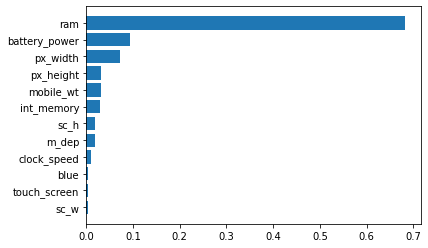

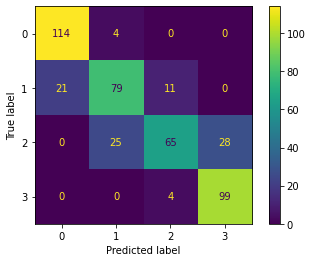

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}


In [24]:
parameters = {'n_estimators':[100, 200], "criterion": ['gini', 'entropy'],
              'bootstrap': [True, False], 'max_depth': [2, 3]
             }
grid_search = GridSearchCV(RandomForestClassifier(), parameters)
fit_grid_search_and_evaluate_best_estimator(grid_search, X_train_prepared, y_train, X_validation_prepared, y_validation)
print(grid_search.best_params_)

### Elegimos el modelo definitivo

Recall: 0.8931473360300105
Precision: 0.891427791743262
Accuracy: 0.89
F1 Score: 0.8920899829391247


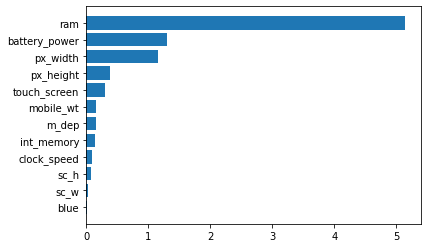

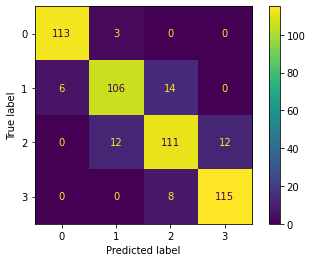

In [25]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

model = SVC(C=1, decision_function_shape='ovo', gamma='scale', kernel='linear')

model = predict_and_evaluate(model, X_train_prepared, y_train, X_test_prepared, y_test)

In [26]:
DATA_FILEPATH = '../data/mobile_phone_test.csv'
test = pd.read_csv(DATA_FILEPATH)

In [27]:
X_test_predict = full_pipeline.fit_transform(test)

model.predict(X_test_predict)

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       2, 1, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 0, 3, 3, 3, 0, 2, 1, 1,
       1, 2, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 0, 3, 2, 1, 2, 0, 3, 2, 2, 1, 0, 2,
       1, 1, 3, 1, 2, 0, 3, 2, 1, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 1, 0,
       3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 3, 2, 0, 2, 2,
       2, 3, 1, 2, 3, 2, 3, 2, 2, 1, 1, 0, 1, 3, 0, 2, 3, 3, 0, 2, 0, 3,
       2, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 3, 0, 3, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 2, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 0, 2, 3, 1, 1, 3, 2, 0, 3, 0, 1, 2, 0, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 2, 2, 1, 1, 0, 2, 3, 1,

https://www.kaggle.com/gulsahdemiryurek/mobile-price-classification-with-svm/

https://www.kaggle.com/iabhishekofficial/mobile-price-classification/

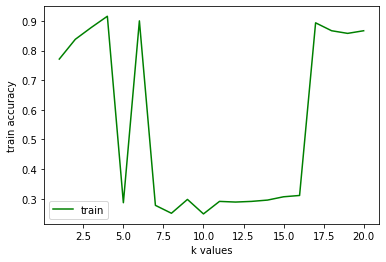

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


num_attribs = ['battery_power', 'int_memory', 'n_cores', 'px_height', 'ram']
cat_attribs = ['four_g', 'touch_screen']

num_attribs = ['battery_power','clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w','talk_time']
cat_attribs = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
    
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", DummyTransformer(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_validation_prepared = full_pipeline.fit_transform(X_validation)

svm=SVC(random_state=1)
accuracy_list_train = []

k=np.arange(1,21,1)

for each in k:
    selector = SelectKBest(f_classif, k = each)
    x_new = selector.fit_transform(X_train_prepared, y_train)
    x_validation_new = selector.fit_transform(X_validation_prepared, y_validation)
    svm.fit(x_new,y_train)
    accuracy_list_train.append(svm.score(x_validation_new, y_validation))   
    
plt.plot(k,accuracy_list_train,color="green",label="train")
plt.xlabel("k values")
plt.ylabel("train accuracy")
plt.legend()
plt.show()

In [29]:
d = {'best features number': k, 'train_score': accuracy_list_train}
results_df = pd.DataFrame(data=d)
print("max accuracy:", results_df["train_score"].max())
print("max accuracy id:", results_df["train_score"].idxmax())

max accuracy: 0.9155555555555556
max accuracy id: 3


In [30]:
selector = SelectKBest(f_classif, k = 18)
x_new = selector.fit_transform(X_train, y_train)
x_new_test=selector.fit_transform(X_validation,y_validation)
names_train = X_train.columns.values[selector.get_support()]
names_test = X_validation.columns.values[selector.get_support()]
print("x train features:", names_train)
print("x test features:", names_test)

x train features: ['battery_power' 'blue' 'clock_speed' 'dual_sim' 'fc' 'int_memory' 'm_dep'
 'mobile_wt' 'pc' 'px_height' 'px_width' 'ram' 'sc_h' 'sc_w' 'talk_time'
 'three_g' 'touch_screen' 'wifi']
x test features: ['battery_power' 'blue' 'clock_speed' 'dual_sim' 'fc' 'int_memory' 'm_dep'
 'mobile_wt' 'pc' 'px_height' 'px_width' 'ram' 'sc_h' 'sc_w' 'talk_time'
 'three_g' 'touch_screen' 'wifi']


In [31]:
num_attribs = ['battery_power','clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w','talk_time']
cat_attribs = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
    
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", DummyTransformer(), cat_attribs),
    ])

selector = SelectKBest(f_classif, k = 3)

X_train_prepared = full_pipeline.fit_transform(X_train, y_train)
X_train_prepared = selector.fit_transform(X_train_prepared, y_train)

X_validation_prepared = full_pipeline.fit_transform(X_validation, y_validation)
X_validation_prepared = selector.fit_transform(X_validation_prepared, y_validation)

In [32]:
svm=SVC(random_state=1)
svm.fit(X_train_prepared, y_train)
print(svm.score(X_validation_prepared, y_validation))

y_predicted = svm.predict(X_validation_prepared)
print("Recall:", recall_score(y_validation, y_predicted, average='macro'))
print("Precision:", precision_score(y_validation, y_predicted, average='macro'))
print("Accuracy:", accuracy_score(y_validation, y_predicted))
print("F1 Score:", f1_score(y_validation, y_predicted, average='macro'))
    

0.8777777777777778
Recall: 0.8783340893962911
Precision: 0.8786400223293428
Accuracy: 0.8777777777777778
F1 Score: 0.8784638044434878


In [33]:
#svm_model=SVC(C=2,decision_function_shape="ovo",gamma="auto",kernel="linear",random_state=1)

#svm_model = predict_and_evaluate(svm_model, X_train_prepared, y_train, X_validation_prepared, y_validation)

Recall: 0.9023452970572399
Precision: 0.9025107942595572
Accuracy: 0.9
F1 Score: 0.9023606498535215


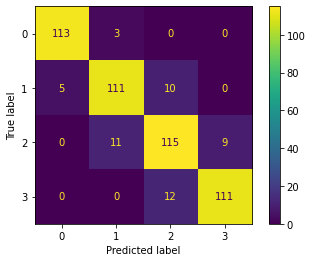

SVC(random_state=1)

In [34]:
X_test_prepared = full_pipeline.fit_transform(X_test, y_test)
X_test_prepared = selector.fit_transform(X_test_prepared, y_test)

predict_and_evaluate(svm, X_train_prepared, y_train, X_test_prepared, y_test)

In [35]:
C=[1,0.1,0.25,0.5,2,0.75]
kernel=["linear","rbf"]
gamma=["auto",0.01,0.001,0.0001,1]
decision_function_shape=["ovo","ovr"]

svm=SVC(random_state=1)
grid_svm=GridSearchCV(estimator=svm,cv=5,param_grid=dict(kernel=kernel,C=C, gamma=gamma, decision_function_shape=decision_function_shape))
grid_svm.fit(X_train_prepared, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)

KeyboardInterrupt: 

In [ ]:
selector = SelectKBest(f_classif, k = 3)
x_new = selector.fit_transform(X_train, y_train)

C=[1,0.1,0.25,0.5,2,0.75]
kernel=["linear","rbf"]
gamma=["auto",0.01,0.001,0.0001,1]
decision_function_shape=["ovo","ovr"]

svm=SVC(random_state=1)
grid_svm=GridSearchCV(estimator=svm,cv=5,param_grid=dict(kernel=kernel,C=C, gamma=gamma, decision_function_shape=decision_function_shape))
grid_svm.fit(x_new, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)

In [ ]:
grid_svm.best_estimator_.score(selector.fit_transform(X_test, y_test), y_test)

In [ ]:
evaluate(grid_svm.best_estimator_, X_train_prepared, y_train, selector.fit_transform(X_test, y_test), y_test)

In [ ]:
https://docs.microsoft.com/en-us/python/api/overview/azure/ml/?view=azure-ml-py

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k = 3)
selector.fit_transform(X_train, y_train)
X_train_prepared = selector.fit_transform(X_train, y_train)

In [14]:
a = pd.DataFrame(X_train_prepared)
a['price_range'] = y_train.fillna(0)
a['price_range'] = a['price_range'].fillna(0)

In [15]:
y_train

1851    3
1883    0
443     1
196     2
832     0
       ..
1127    2
1377    3
610     0
1209    1
212     0
Name: price_range, Length: 1050, dtype: int64

In [16]:
a

,0,1,2,price_range
0,1077.0,1079.0,3454.0,0.0
1,1205.0,1870.0,953.0,2.0
2,1448.0,1850.0,1175.0,0.0
3,1989.0,1497.0,1665.0,0.0
4,1860.0,799.0,676.0,1.0
...,...,...,...,...
1045,618.0,1602.0,2262.0,2.0
1046,1071.0,1970.0,3393.0,3.0
1047,1430.0,906.0,752.0,0.0
1048,1895.0,1335.0,774.0,3.0


In [36]:
y = df['price_range']
X = df.drop(['price_range'], axis=1)

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k = 3)
selector.fit_transform(X, y)
X_train_prepared = selector.fit_transform(X, y)

In [23]:
X_train_prepared

array([[ 842.,  756., 2549.],
       [1021., 1988., 2631.],
       [ 563., 1716., 2603.],
       ...,
       [1911., 1632., 3057.],
       [1512.,  670.,  869.],
       [ 510.,  754., 3919.]])

In [24]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [8]:
a

,0,1,2,price_range
0,842.0,756.0,2549.0,1
1,1021.0,1988.0,2631.0,2
2,563.0,1716.0,2603.0,2
3,615.0,1786.0,2769.0,2
4,1821.0,1212.0,1411.0,1
...,...,...,...,...
1995,794.0,1890.0,668.0,0
1996,1965.0,1965.0,2032.0,2
1997,1911.0,1632.0,3057.0,3
1998,1512.0,670.0,869.0,0


In [10]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X_train_prepared, y, test_size=0.25, random_state=1)

In [14]:
y_test

674     0
1699    0
1282    1
1315    1
1210    2
       ..
537     2
1450    0
1919    0
255     2
589     0
Name: price_range, Length: 500, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_prepared, y, test_size=0.25, random_state=1)

In [19]:
X_train_prepared = pd.DataFrame(X_train)
X_train_prepared['price_range'] = y_train
X_train_prepared

,0,1,2,price_range
0,1784.0,1437.0,2313.0,NaN
1,1939.0,520.0,1047.0,2.0
2,598.0,764.0,3066.0,NaN
3,1821.0,1803.0,2430.0,NaN
4,1494.0,1003.0,1208.0,1.0
...,...,...,...,...
1120,618.0,1602.0,2262.0,3.0
1121,1071.0,1970.0,3393.0,3.0
1122,1430.0,906.0,752.0,3.0
1123,1895.0,1335.0,774.0,NaN


In [26]:
X_train_prepared

array([[ 842.,  756., 2549.],
       [1021., 1988., 2631.],
       [ 563., 1716., 2603.],
       ...,
       [1911., 1632., 3057.],
       [1512.,  670.,  869.],
       [ 510.,  754., 3919.]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_prepared, y, test_size=0.25, random_state=1)

In [32]:
X_test_prepared = pd.DataFrame(X_test)
X_test_prepared['price_range'] = y_test

In [33]:
X_test_prepared

,0,1,2,price_range
0,1034.0,1293.0,969.0,1.0
1,1002.0,1007.0,1234.0,NaN
2,609.0,1524.0,1905.0,NaN
3,1510.0,1520.0,854.0,2.0
4,805.0,1544.0,3397.0,NaN
...,...,...,...,...
495,737.0,1463.0,2951.0,NaN
496,1249.0,1193.0,531.0,NaN
497,1318.0,661.0,755.0,NaN
498,973.0,1816.0,2977.0,NaN


In [34]:
caca = pd.DataFrame(X_train)
caca['price_range'] = y_train
caca

,0,1,2,price_range
0,1315.0,575.0,3278.0,NaN
1,989.0,1069.0,1737.0,2.0
2,1229.0,1878.0,1667.0,2.0
3,920.0,1421.0,2608.0,NaN
4,1654.0,1719.0,1070.0,1.0
...,...,...,...,...
1495,1203.0,510.0,1672.0,0.0
1496,1154.0,1827.0,3262.0,NaN
1497,718.0,997.0,1601.0,3.0
1498,1523.0,1606.0,707.0,1.0


In [37]:
df2 = df.copy()

In [38]:
X.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [39]:
selector = SelectKBest(f_classif, k = 3)

In [42]:
df2 = selector.fit_transform(df2[X.columns], y)

In [43]:
df2

array([[ 842.,  756., 2549.],
       [1021., 1988., 2631.],
       [ 563., 1716., 2603.],
       ...,
       [1911., 1632., 3057.],
       [1512.,  670.,  869.],
       [ 510.,  754., 3919.]])

In [55]:
caca = pd.DataFrame(df2)
caca['price_range'] = y

In [56]:
cacay = caca['price_range']
cacaX = caca.drop(['price_range'], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    cacaX, cacay, test_size=0.25, random_state=1)

In [60]:
cacay

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [61]:
caca = pd.DataFrame(X_train)
caca['price_range'] = y_train

In [62]:
caca

,0,1,2,price_range
650,1315.0,575.0,3278.0,2
1104,989.0,1069.0,1737.0,1
561,1229.0,1878.0,1667.0,1
643,920.0,1421.0,2608.0,2
441,1654.0,1719.0,1070.0,1
...,...,...,...,...
1791,1203.0,510.0,1672.0,0
1096,1154.0,1827.0,3262.0,3
1932,718.0,997.0,1601.0,1
235,1523.0,1606.0,707.0,0


In [90]:
df = pd.read_csv(DATA_FILEPATH)

y = df['price_range']
X = df.drop(['price_range'], axis=1)

selector = SelectKBest(f_classif, k = 3)

prepared_df = pd.DataFrame(selector.fit_transform(df[X.columns], y))

X_train, X_test, y_train, y_test = train_test_split(
    prepared_df, y, test_size=0.25, random_state=1)

X_train_prepared = pd.DataFrame(X_train)
X_train_prepared['price_range'] = y_train

X_test_prepared = pd.DataFrame(X_test)
X_test_prepared['price_range'] = y_test

In [91]:
X_train_prepared

,0,1,2,price_range
650,1315.0,575.0,3278.0,2
1104,989.0,1069.0,1737.0,1
561,1229.0,1878.0,1667.0,1
643,920.0,1421.0,2608.0,2
441,1654.0,1719.0,1070.0,1
...,...,...,...,...
1791,1203.0,510.0,1672.0,0
1096,1154.0,1827.0,3262.0,3
1932,718.0,997.0,1601.0,1
235,1523.0,1606.0,707.0,0


In [80]:
X_test_prepared

,0,1,2,price_range
674,1034.0,1293.0,969.0,0
1699,1002.0,1007.0,1234.0,0
1282,609.0,1524.0,1905.0,1
1315,1510.0,1520.0,854.0,1
1210,805.0,1544.0,3397.0,2
...,...,...,...,...
537,737.0,1463.0,2951.0,2
1450,1249.0,1193.0,531.0,0
1919,1318.0,661.0,755.0,0
255,973.0,1816.0,2977.0,2
